In [1]:
import numpy as np
import pandas as pd
import os
import random
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
register_matplotlib_converters()

from statsmodels.tsa.vector_ar.var_model import VAR

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator



import statsmodels.api as sm


gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 1., allow_growth=True)
   
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)  

In [2]:
os.chdir('/home/nnlinux/Documentos/git-repos/doutorado/phD-thesis-project/')

       Agropecuária  Indústria  Infraestrutura  Comércio e serviços  \
count     72.000000  72.000000       72.000000            72.000000   
mean       0.135622   0.565348        0.495093             0.219978   
std        0.065522   0.458333        0.270936             0.153548   
min        0.053407   0.028426        0.085215             0.022447   
25%        0.091239   0.265550        0.274034             0.104358   
50%        0.118062   0.540207        0.491297             0.175733   
75%        0.149423   0.709280        0.658696             0.336986   
max        0.370092   2.638441        1.143117             0.832406   

           Total  Investimento  
count  72.000000     72.000000  
mean    1.416042     17.987601  
std     0.779904      2.096092  
min     0.202680     14.268541  
25%     0.939751     16.376876  
50%     1.439447     17.847753  
75%     1.773297     20.039805  
max     3.913393     21.525857  


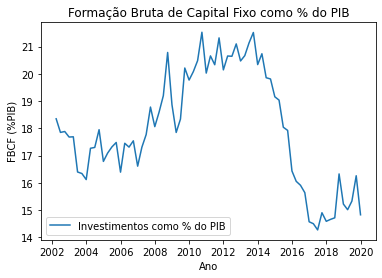

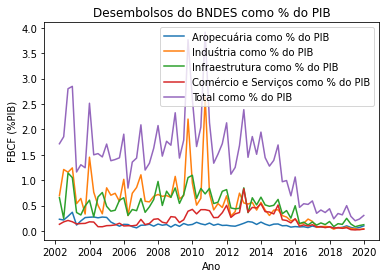

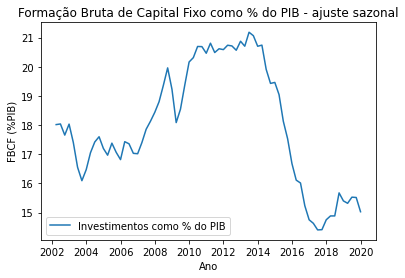

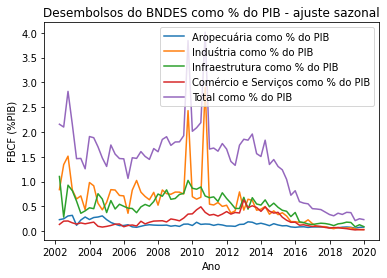

,Inv,Agr,Ind,Inf,Com
date,,,,,
2002-03-31,18.017116,0.231266,0.836440,1.101536,0.135042
2002-04-30,18.024239,0.237004,1.004470,0.828353,0.157193
2002-05-31,18.031363,0.242741,1.172500,0.555169,0.179344
2002-06-30,18.038487,0.248479,1.340529,0.281986,0.201495
2002-07-31,17.911289,0.267514,1.397601,0.496783,0.202467


In [3]:
### READ DATA ###

# Carrega os dados
github_repo = 'https://raw.githubusercontent.com/carlosvneves/doutorado/master/'
desembolsos = pd.read_csv(github_repo + 'desembolsos.csv')
pib = pd.read_csv(github_repo +'pib.csv')
fbcf = pd.read_csv(github_repo +'fbcf.csv') 

fbcf.index = pd.to_datetime(fbcf['date'])
fbcf.drop(['date'],inplace=True, axis = 1)

    
pib.index = pd.to_datetime(pib['date'])
pib.drop(['date'],inplace=True, axis = 1)


desembolsos.index = pd.to_datetime(desembolsos['date'])
desembolsos.drop(['date'], inplace=True, axis = 1)
    
data = desembolsos.groupby(pd.PeriodIndex(desembolsos.index, freq='Q')).mean()
data = data.loc['1996Q1':]
data.index = data.index.to_timestamp(freq='Q')

for col in data.columns:
    data[col] = data[col]/pib['pib'].values * 100
    
    
# Corte da série de acordo com a análise de tendência
start = '2002Q1'

data['Investimento'] = fbcf['fbcf'].values/pib['pib'].values *100
data = data.loc[start:]

print(data.describe())


# Visualiza os dados originais
plt.figure()
plt.plot(data.index,data[['Investimento']],
          label = 'Investimentos como % do PIB')
plt.xlabel('Ano')
plt.ylabel('FBCF (%PIB)')
plt.legend()
plt.title('Formação Bruta de Capital Fixo como % do PIB')
#plt.savefig('investimentos')
plt.show()

plt.figure()
plt.plot(data.index,data[['Agropecuária']],
          label = 'Aropecuária como % do PIB')
plt.plot(data.index,data[['Indústria']],
          label = 'Induśtria como % do PIB')
plt.plot(data.index,data[['Infraestrutura']],
          label = 'Infraestrutura como % do PIB')
plt.plot(data.index,data[['Comércio e serviços']],
          label = 'Comércio e Serviços como % do PIB')
plt.plot(data.index,data[['Total']],
          label = 'Total como % do PIB')
plt.title('Desembolsos do BNDES como % do PIB')
plt.xlabel('Ano')
plt.ylabel('FBCF (%PIB)')
plt.legend()
#plt.savefig('desembolsos')
plt.show()
  


data[['Agropecuária','Indústria','Infraestrutura','Comércio e serviços', 'Total']]


# Ajuste Sazonal (X-13 ARIMA) das séries para otimizar a modelagem
X13_PATH = os.path.join('x13/')

data_sa = pd.DataFrame(data)
data_sa.rename(columns=lambda x: x[0:3], inplace=True)

for col in data_sa:
  sa = sm.tsa.x13_arima_analysis(data_sa[col],x12path=X13_PATH)
  data_sa[col] = sa.seasadj.values

data_sa.tail()


# Visualiza dados com ajuste sazonal 

plt.figure()
plt.plot(data_sa.index,data_sa[['Inv']],
        label = 'Investimentos como % do PIB')
plt.xlabel('Ano')
plt.ylabel('FBCF (%PIB)')
plt.legend()
plt.title('Formação Bruta de Capital Fixo como % do PIB - ajuste sazonal')
#plt.savefig('investimentos-sa')
plt.show()

plt.figure()
plt.plot(data_sa.index,data_sa[['Agr']],
        label = 'Aropecuária como % do PIB')
plt.plot(data_sa.index,data_sa[['Ind']],
        label = 'Induśtria como % do PIB')
plt.plot(data_sa.index,data_sa[['Inf']],
        label = 'Infraestrutura como % do PIB')
plt.plot(data_sa.index,data_sa[['Com']],
        label = 'Comércio e Serviços como % do PIB')
plt.plot(data_sa.index,data_sa[['Tot']],
        label = 'Total como % do PIB')
plt.title('Desembolsos do BNDES como % do PIB - ajuste sazonal')
plt.xlabel('Ano')
plt.ylabel('FBCF (%PIB)')
plt.legend()
#plt.savefig('desembolsos-sa')
plt.show() 
#  Unsample dos dados de Trim para Mensal
upsampled = data_sa.resample('M')
interpolated = upsampled.interpolate(method='linear')
interpolated.tail(24)

data = interpolated
data = data[['Inv','Agr','Ind','Inf','Com']]
data.head() 

In [4]:
### ADJUST AND CLEAN DATA ###

df_external = data[['Agr','Ind','Inf','Com']]

df_external.head()

,Agr,Ind,Inf,Com
date,,,,
2002-03-31,0.231266,0.836440,1.101536,0.135042
2002-04-30,0.237004,1.004470,0.828353,0.157193
2002-05-31,0.242741,1.172500,0.555169,0.179344
2002-06-30,0.248479,1.340529,0.281986,0.201495
2002-07-31,0.267514,1.397601,0.496783,0.202467


In [5]:
### SPLIT TRAIN TEST ###
split = 0.75

train_date = data.index[:int(len(data)*split)]
train = data[:int(len(data)*split)].copy()

test_date = data.index[int(len(data)*split):]
test = data[int(len(data)*split):].copy()

print(train.shape, test.shape)

(160, 5) (54, 5)


In [6]:
### PLOTTING UTILITY FUNCTIONS ###

def plot_sensor(name):
    
    plt.figure(figsize=(16,4))

    plt.plot(train_date, train[name], label='train')
    plt.plot(test_date, test[name], label='test')
    plt.ylabel(name); plt.legend()
    plt.show()
    
def plot_autocor(name, df):
    
    plt.figure(figsize=(16,4))
    
    # pd.plotting.autocorrelation_plot(df[name])
    # plt.title(name)
    # plt.show()
    
    timeLags = np.arange(1,100*24)
    plt.plot([df[name].autocorr(dt) for dt in timeLags])
    plt.title(name); plt.ylabel('autocorr'); plt.xlabel('time lags')
    plt.show()

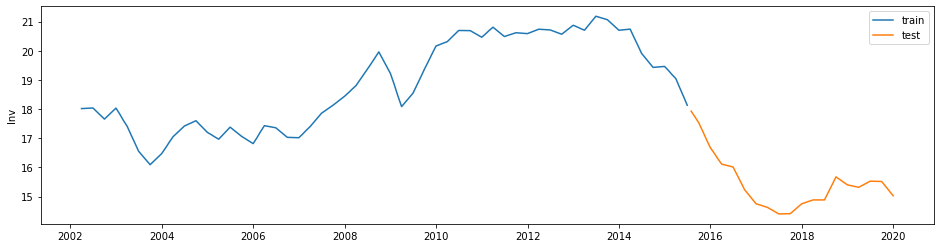

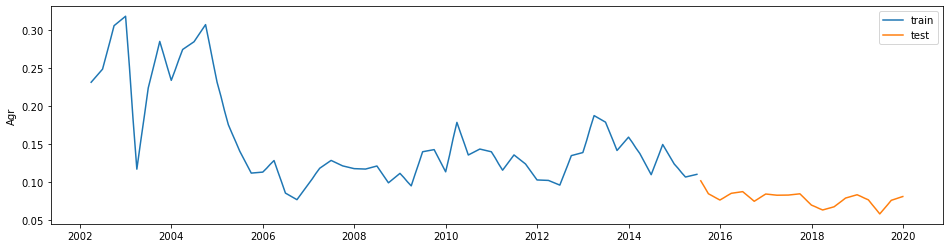

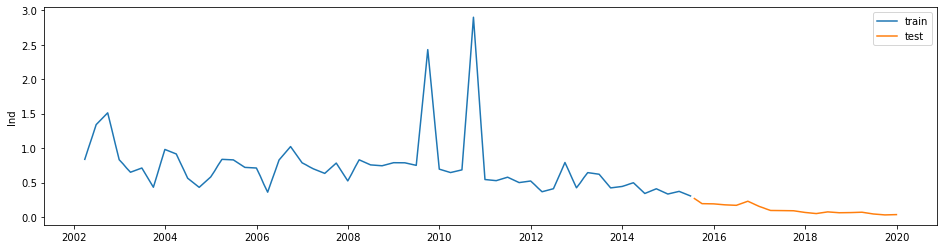

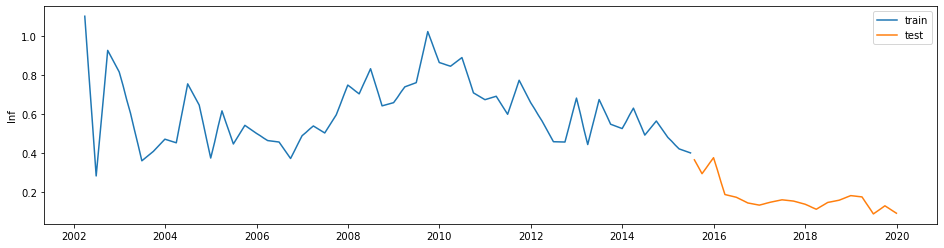

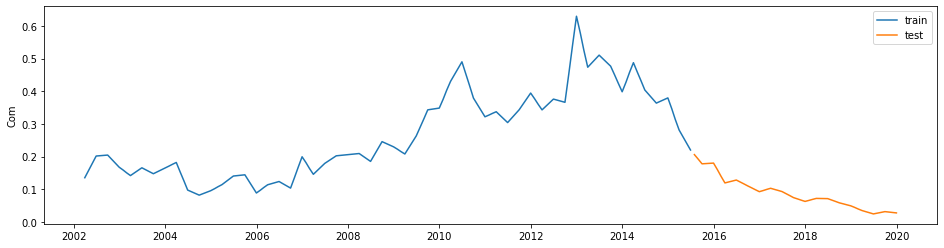

In [7]:
### PLOT ORIGINAL SERIES ###

for col in data.columns:
    plot_sensor(col)

/home/nnlinux/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/nnlinux/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


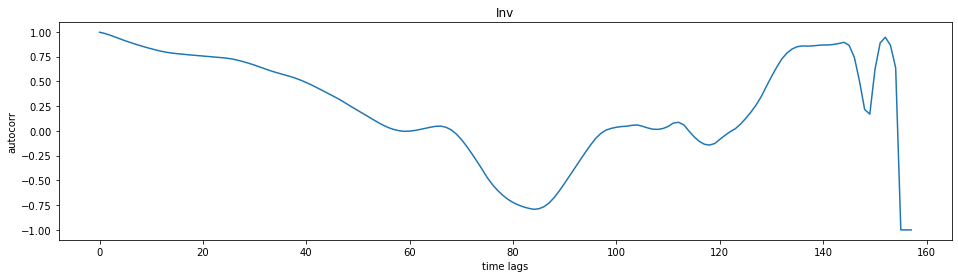

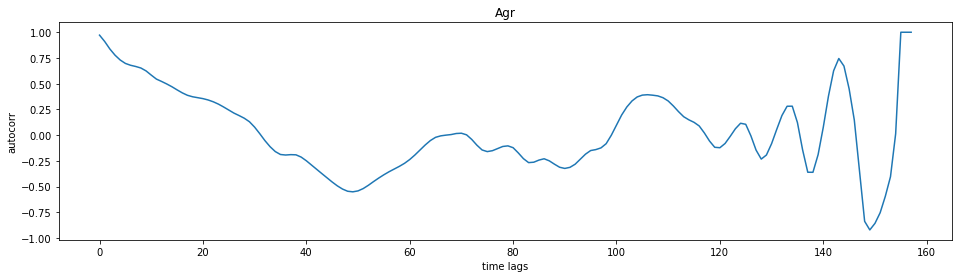

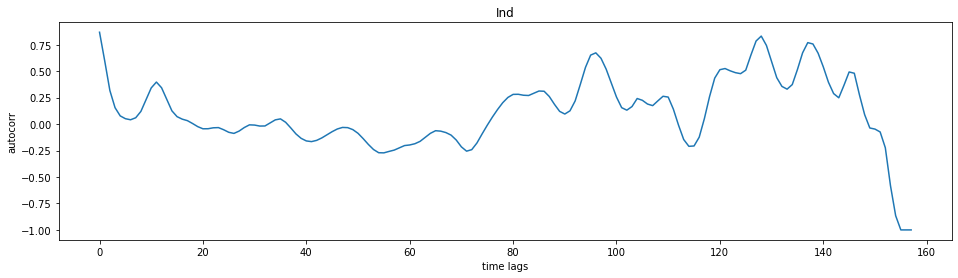

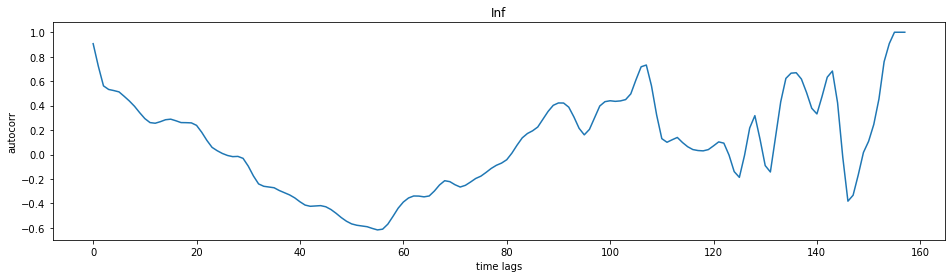

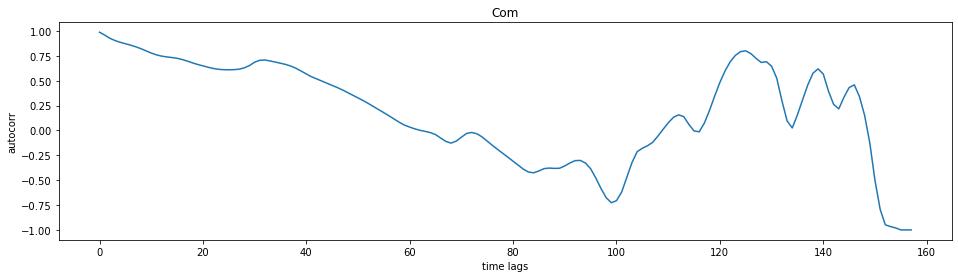

In [8]:
### PLOT AUTOCORRELATION ###

for col in data.columns:
    plot_autocor(col, train)

In [9]:
### OPERATE DIFFERENTIATION ###
period = 1

df_diff = data.diff(period).dropna()
df_external = df_external.iloc[period:].copy()

In [10]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.10:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [11]:
adf_test(df_diff['Inv'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.694556
p-value                   0.074985
# lags used              12.000000
# observations          200.000000
critical value (1%)      -3.463476
critical value (5%)      -2.876102
critical value (10%)     -2.574532
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [12]:
adf_test(df_diff['Agr'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.338216
p-value                   0.000381
# lags used              15.000000
# observations          197.000000
critical value (1%)      -3.463987
critical value (5%)      -2.876326
critical value (10%)     -2.574652
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [13]:
adf_test(df_diff['Ind'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.418187
p-value                   0.000276
# lags used              15.000000
# observations          197.000000
critical value (1%)      -3.463987
critical value (5%)      -2.876326
critical value (10%)     -2.574652
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [14]:
adf_test(df_diff['Inf'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.005986
p-value                   0.001379
# lags used              15.000000
# observations          197.000000
critical value (1%)      -3.463987
critical value (5%)      -2.876326
critical value (10%)     -2.574652
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [15]:
adf_test(df_diff['Com'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.745439
p-value                   0.066500
# lags used              15.000000
# observations          197.000000
critical value (1%)      -3.463987
critical value (5%)      -2.876326
critical value (10%)     -2.574652
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [16]:
### SPLIT DIFFERENTIAL DATA IN TRAIN AND TEST ###

train_diff = df_diff.iloc[:len(train)-period,:].copy()
test_diff = df_diff.iloc[len(train)-period:,:].copy()

train_init = data.iloc[:len(train)-period,:].copy()
test_init = data.iloc[len(train)-period:-period,:].copy()

train_ext = df_external.iloc[:len(train)-period,:].copy()
test_ext = df_external.iloc[len(train)-period:,:].copy()

print(train_diff.shape, train_init.shape, train_ext.shape)
print(test_diff.shape, test_init.shape, test_ext.shape)

(159, 5) (159, 5) (159, 4)
(54, 5) (54, 5) (54, 4)


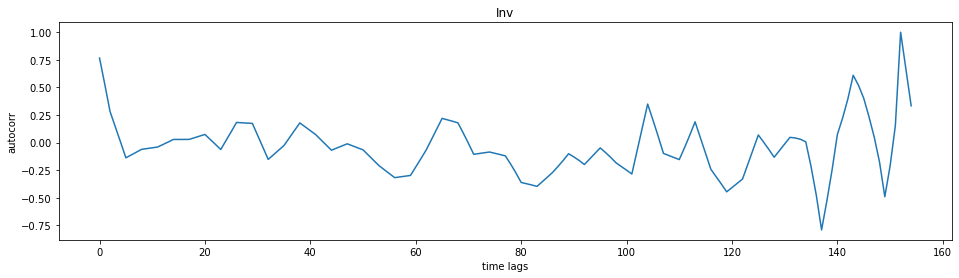

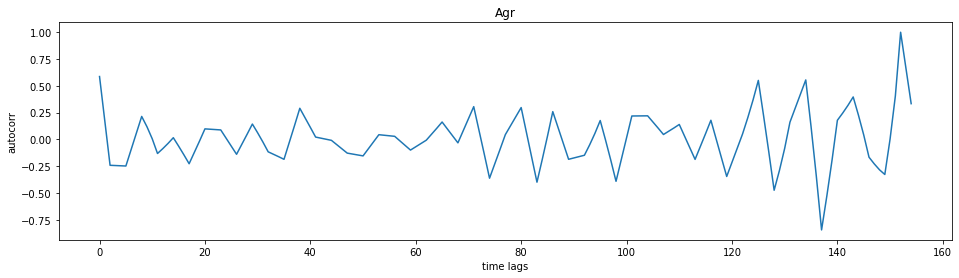

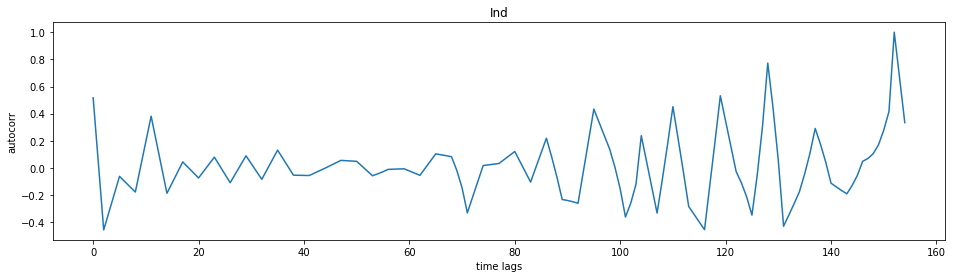

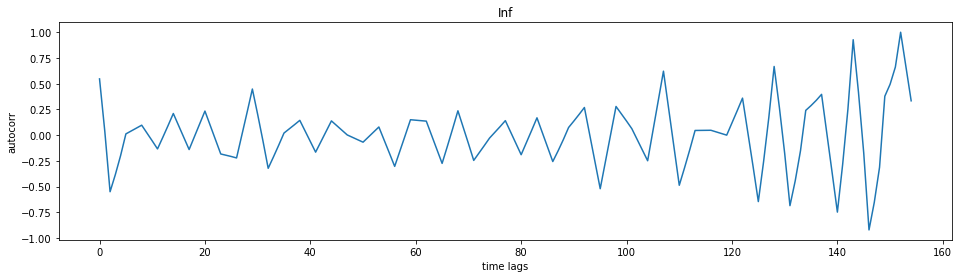

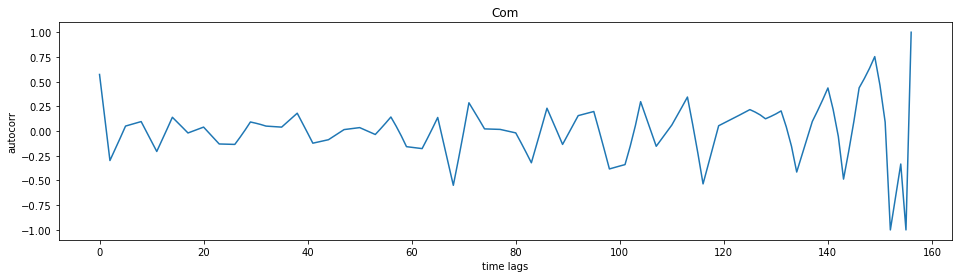

In [17]:
### PLOT DIFFERENTIAL SERIES ###

for col in data.columns:
    plot_autocor(col, train_diff)

In [64]:
### FIND BEST VAR ORDER ###

AIC = {}
best_aic, best_order = np.inf, 0

for i in range(1,10):
    model = VAR(endog=train_diff.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

BEST ORDER 7 BEST AIC: -33.995835260118014


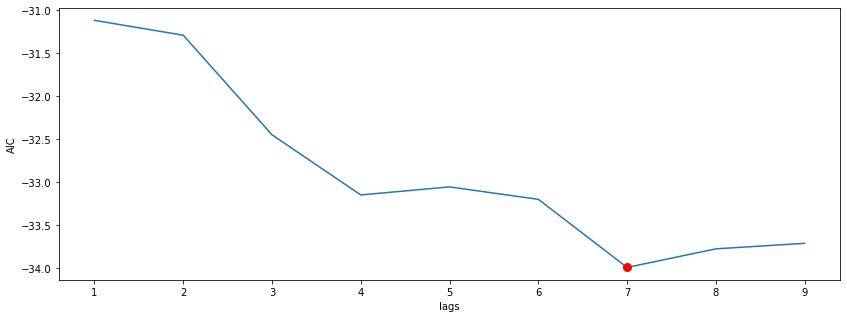

In [65]:
### PLOT AICs ### 

plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(len(AIC)), range(1,50))
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

In [66]:
### FIT FINAL VAR WITH LAG CORRESPONTING TO THE BEST AIC ###

var = VAR(endog=train_diff.values)
var_result = var.fit(maxlags=best_order)
var_result.aic

-33.995835260118014

# VAR LONG-TERM PREDICTION

In [67]:
### UTILITY FUNCTION FOR RETRIVE VAR PREDICTIONS ###

def retrive_prediction(prior, prior_init, steps):
    
    pred = var_result.forecast(np.asarray(prior), steps=steps)
    init = prior_init.tail(period).values
    
    if steps > period:
        id_period = list(range(period))*(steps//period)
        id_period = id_period + list(range(steps-len(id_period)))
    else:
        id_period = list(range(steps))
    
    final_pred = np.zeros((steps, prior.shape[1]))
    for j, (i,p) in enumerate(zip(id_period, pred)):
        final_pred[j] = init[i]+p
        init[i] = init[i]+p    
        
    return final_pred

In [68]:
train_date[-1]

Timestamp('2015-06-30 00:00:00', freq='M')

In [69]:
### RETRIVE PREDICTION AND OBTAIN THE CORRESPONDING ACTUAL VALUES ###

date = train_date[-1]
forward = test.shape[0]
date_range = pd.date_range(date, periods=forward+1, freq='M', closed='right')

final_pred = retrive_prediction(df_diff.loc[:date], data.loc[:date], steps = forward)
final_true = data.loc[date_range]

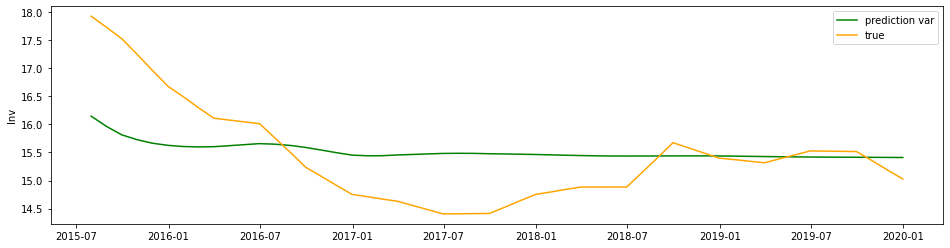

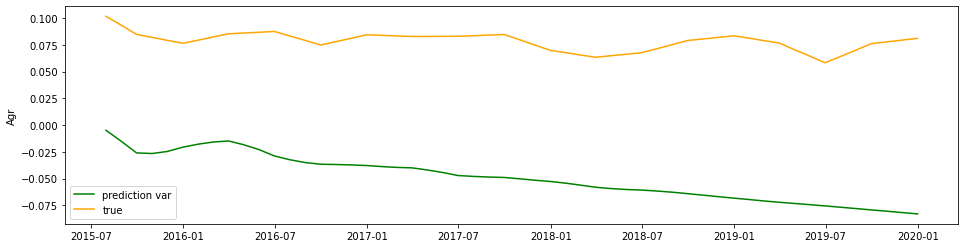

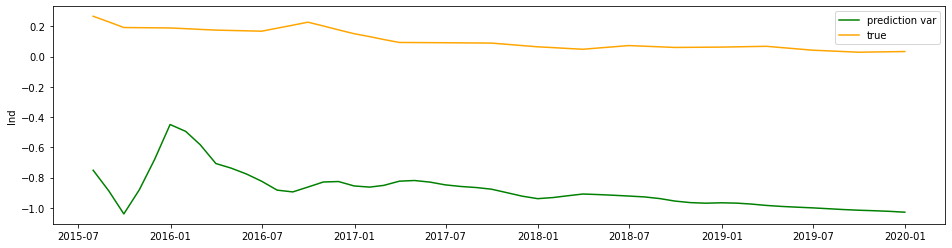

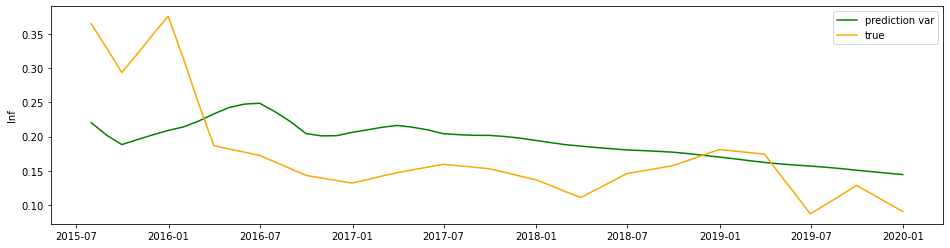

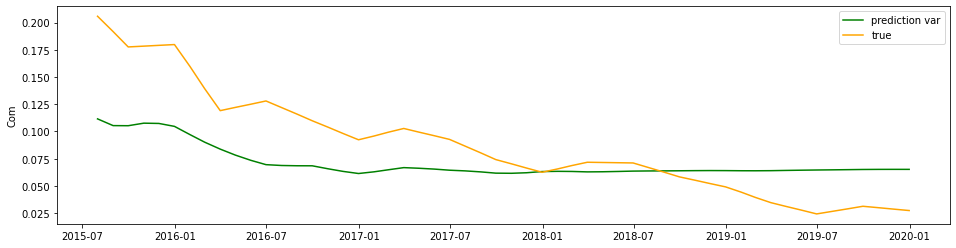

In [70]:
### PLOT ACTUAL vs PREDICTION ###

for i,col in enumerate(data.columns):

    plt.figure(figsize=(16,4))
    plt.plot(date_range, final_pred[:,i], c='green', label='prediction var')
    plt.plot(date_range, final_true[col].values, c='orange', label='true')
    plt.ylabel(col); plt.legend()
    plt.show()

# COMBINE VAR AND LSTM

In [71]:
### UTILITY FUNCTIONS FOR NEURAL NETWORK TRAINING ###

def autocor_pred(real, pred, lag=1):
    return pearsonr(real[:-lag], pred[lag:])[0]


seq_length = 36

def get_model():
    
    opt = RMSprop(lr=1e-4)
    
    inp = Input(shape=(seq_length, test.shape[0]))
    
    x = LSTM(300)(inp)
    x = Dropout(0.5)(x)
    x = Dense(175, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    out = Dense(5)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=opt, loss='mse')
    
    return model

In [72]:
### GET TRAIN VALIDATION AND TEST DATA FOR NEURAL NETWORK ###

X = var_result.fittedvalues

y_train = train.iloc[period+best_order:].values
y_train_var = X + train_init.iloc[best_order:].values
X_train = np.concatenate([train_diff.iloc[best_order:].values, train_ext.iloc[best_order:].values], axis=1)
X_train_var = np.concatenate([X, train_ext.iloc[best_order:].values], axis=1)

y_val = y_train[int(len(X)*split):]
y_val_var = y_train_var[int(len(X)*split):]
X_val = X_train[int(len(X)*split):]
X_val_var = X_train_var[int(len(X)*split):]

y_train = y_train[:int(len(X)*split)]
y_train_var = y_train_var[:int(len(X)*split)]
X_train = X_train[:int(len(X)*split)]
X_train_var = X_train_var[:int(len(X)*split)]

y_test = test.values
X_test = np.concatenate([test_diff.values, test_ext.values], axis=1)

In [73]:
### SCALE DATA ###

scaler_y = StandardScaler()
scaler = StandardScaler()

y_train = scaler_y.fit_transform(y_train)
y_train_var = scaler_y.transform(y_train_var)
y_val = scaler_y.transform(y_val)
y_val_var = scaler_y.transform(y_val_var)
y_test = scaler_y.transform(y_test)

X_train = scaler.fit_transform(X_train)
X_train_var = scaler.transform(X_train_var)
X_val = scaler.transform(X_val)
X_val_var = scaler.transform(X_val_var)
X_test = scaler.transform(X_test)

In [74]:
### BUILD DATA GENERATOR ###

generator_train = TimeseriesGenerator(X_train, y_train, length=seq_length, batch_size=32)
generator_train_var = TimeseriesGenerator(X_train_var, y_train_var, length=seq_length, batch_size=32)
generator_val = TimeseriesGenerator(X_val, y_val, length=seq_length, batch_size=32)
generator_val_var = TimeseriesGenerator(X_val_var, y_val_var, length=seq_length, batch_size=32)
generator_test = TimeseriesGenerator(X_test, y_test, length=seq_length, batch_size=32)

In [75]:
### FIT NEURAL NETWORK WITH VAR FITTED VALUES AND RAW DATA ###

tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


es = EarlyStopping(patience=30, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

print('--------', 'train model with VAR fitted values', '--------')
model_var = get_model()
model_var.fit_generator(generator_train_var, steps_per_epoch= len(generator_train_var),
                        epochs=100, validation_data=generator_val_var, validation_steps = len(generator_val_var), 
                        callbacks=[es], verbose = 1)


print('--------', 'train model with raw data', '--------')
model_var.fit_generator(generator_train, steps_per_epoch= len(generator_train),
                        epochs=100, validation_data=generator_val, validation_steps = len(generator_val), 
                        callbacks=[es], verbose = 1)

-------- train model with VAR fitted values --------
Epoch 1/100
3/3 [==============================] - 0s 80ms/step - loss: 0.9742 - val_loss: 0.7805
Epoch 2/100
3/3 [==============================] - 0s 14ms/step - loss: 0.9441 - val_loss: 0.7690
Epoch 3/100
3/3 [==============================] - 0s 15ms/step - loss: 0.9243 - val_loss: 0.7578
Epoch 4/100
3/3 [==============================] - 0s 12ms/step - loss: 0.9046 - val_loss: 0.7481
Epoch 5/100
3/3 [==============================] - 0s 13ms/step - loss: 0.8722 - val_loss: 0.7370
Epoch 6/100
3/3 [==============================] - 0s 13ms/step - loss: 0.8734 - val_loss: 0.7287
Epoch 7/100
3/3 [==============================] - 0s 14ms/step - loss: 0.8430 - val_loss: 0.7202
Epoch 8/100
3/3 [==============================] - 0s 13ms/step - loss: 0.8232 - val_loss: 0.7125
Epoch 9/100
3/3 [==============================] - 0s 12ms/step - loss: 0.7907 - val_loss: 0.7047
Epoch 10/100
3/3 [==============================] - 0s 13ms/step 

In [76]:
### OBTAIN PREDICTIONS AND RETRIVE ORIGINAL DATA ###

true = scaler_y.inverse_transform(y_test[seq_length:])

pred = model_var.predict_generator(generator_test)
pred = scaler_y.inverse_transform(pred)

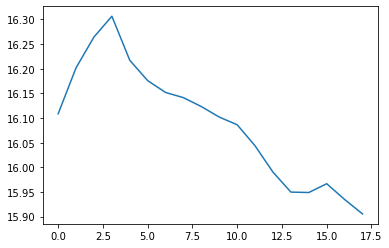

In [77]:
plt.plot(pred[:,0])

In [78]:
### FIT NEURAL NETWORK WITH ONLY ORIGINAL DATA ###

tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


es = EarlyStopping(patience=30, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

simple_model = get_model()
simple_model.fit_generator(generator_train, steps_per_epoch= len(generator_train),
                            epochs=300, validation_data=generator_val, validation_steps = len(generator_val), 
                            callbacks=[es], verbose = 1)

Epoch 1/300
3/3 [==============================] - 0s 83ms/step - loss: 0.9688 - val_loss: 0.7713
Epoch 2/300
3/3 [==============================] - 0s 13ms/step - loss: 0.9360 - val_loss: 0.7588
Epoch 3/300
3/3 [==============================] - 0s 12ms/step - loss: 0.9128 - val_loss: 0.7470
Epoch 4/300
3/3 [==============================] - 0s 13ms/step - loss: 0.8916 - val_loss: 0.7374
Epoch 5/300
3/3 [==============================] - 0s 12ms/step - loss: 0.8655 - val_loss: 0.7252
Epoch 6/300
3/3 [==============================] - 0s 13ms/step - loss: 0.8663 - val_loss: 0.7177
Epoch 7/300
3/3 [==============================] - 0s 13ms/step - loss: 0.8344 - val_loss: 0.7075
Epoch 8/300
3/3 [==============================] - 0s 13ms/step - loss: 0.8141 - val_loss: 0.6999
Epoch 9/300
3/3 [==============================] - 0s 13ms/step - loss: 0.7785 - val_loss: 0.6932
Epoch 10/300
3/3 [==============================] - 0s 13ms/step - loss: 0.7731 - val_loss: 0.6849
Epoch 11/300
3/3 [=

In [79]:
os.chdir('../')### OBTAIN PREDICTIONS ###

pred_simple = simple_model.predict_generator(generator_test)
pred_simple = scaler_y.inverse_transform(pred_simple)

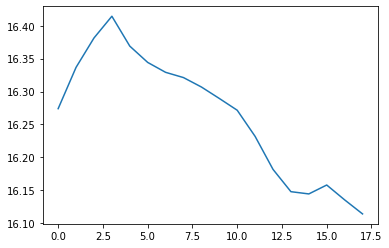

In [80]:
plt.plot(pred_simple[:,0])

In [81]:
### COMPUTE METRICS ON TEST DATA ###

diz_error_lstm, diz_ac_lstm = {}, {}
diz_error_var_lstm, diz_ac_var_lstm = {}, {}


for i,col in enumerate(data.columns):
    
    error = mean_absolute_error(true[:,i], pred_simple[:,i])
    diz_error_lstm[col] = error
    
    error = mean_absolute_error(true[:,i], pred[:,i])
    diz_error_var_lstm[col] = error
    
    ac = autocor_pred(true[:,i], pred_simple[:,i])
    diz_ac_lstm[col] = ac
    
    ac = autocor_pred(true[:,i], pred[:,i])
    diz_ac_var_lstm[col] = ac

In [82]:
### COMPUTE METRICS ON TEST DATA ###

diz_error_lstm2, diz_ac_lstm2 = {}, {}
diz_error_var_lstm2, diz_ac_var_lstm2 = {}, {}


for i,col in enumerate(data.columns):
    
    error = mean_squared_error(true[:,i], pred_simple[:,i])
    diz_error_lstm2[col] = error
    
    error = mean_squared_error(true[:,i], pred[:,i])
    diz_error_var_lstm2[col] = error
    
    ac = autocor_pred(true[:,i], pred_simple[:,i])
    diz_ac_lstm2[col] = ac
    
    ac = autocor_pred(true[:,i], pred[:,i])
    diz_ac_var_lstm2[col] = ac

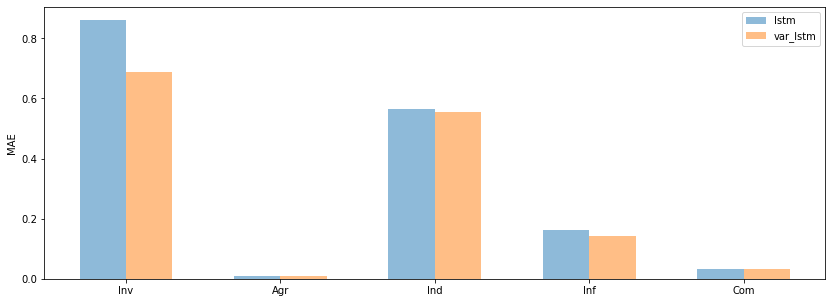

In [83]:
plt.figure(figsize=(14,5))
plt.bar(np.arange(len(diz_error_lstm))-0.15, diz_error_lstm.values(), alpha=0.5, width=0.3, label='lstm')
plt.bar(np.arange(len(diz_error_var_lstm))+0.15, diz_error_var_lstm.values(), alpha=0.5, width=0.3, label='var_lstm')
plt.xticks(range(len(diz_error_lstm)), diz_error_lstm.keys())
plt.ylabel('MAE'); plt.legend()
np.set_printoptions(False)

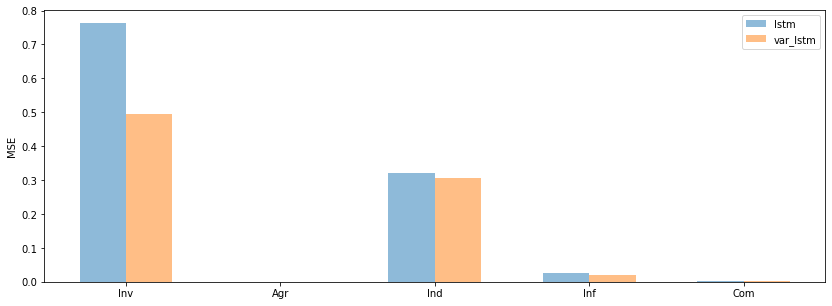

In [84]:
plt.figure(figsize=(14,5))
plt.bar(np.arange(len(diz_error_lstm2))-0.15, diz_error_lstm2.values(), alpha=0.5, width=0.3, label='lstm')
plt.bar(np.arange(len(diz_error_var_lstm2))+0.15, diz_error_var_lstm2.values(), alpha=0.5, width=0.3, label='var_lstm')
plt.xticks(range(len(diz_error_lstm2)), diz_error_lstm2.keys())
plt.ylabel('MSE'); plt.legend()
np.set_printoptions(False)

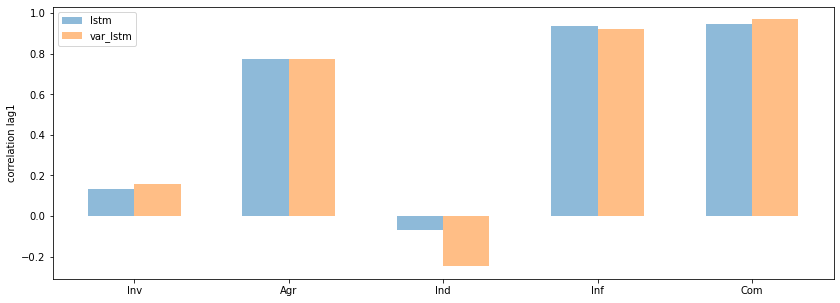

In [85]:
plt.figure(figsize=(14,5))
plt.bar(np.arange(len(diz_ac_lstm))-0.15, diz_ac_lstm.values(), alpha=0.5, width=0.3, label='lstm')
plt.bar(np.arange(len(diz_ac_var_lstm))+0.15, diz_ac_var_lstm.values(), alpha=0.5, width=0.3, label='var_lstm')
plt.xticks(range(len(diz_ac_lstm)), diz_ac_lstm.keys())
plt.ylabel('correlation lag1'); plt.legend()
np.set_printoptions(False)